# 0.- Desciption

This notebook solves the sources updating problem while using the scanner to get the sources observations

In [1]:
# Module import
from IPython.display import Image
import sys
import pandas as pd

# To use interact -- IPython widget
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


# append to path the folder that contains the analytic scanner
sys.path.append('../GaiaLab/scan/analytic_scanner')
# local imports
#from gaia_analytic_toymodel import *

from scipy import interpolate
import timeit

import frame_transformations as ft
from scanner import Scanner
from satellite import Satellite
from source import Source

import constants as const

import quaternion
from agis import Agis
from agis import Calc_source
from agis_functions import *

from analytic_plots import *

import astropy.units as u

# Ipython magics
%load_ext autoreload
%autoreload 2
%matplotlib notebook 
# %matplotlib widget
# %matplotlib ipympl
%reload_ext autoreload


# 1.- **Initializing objects**

In [2]:
True & False

False

In [3]:
# # create all the objects we will need:
# parameters for the notebook
t_init = 0 
t_end =  t_init + 300
my_dt = 1/24/10 # [days]

# objects
gaia = Satellite(ti=t_init, tf=t_end, dt= my_dt)
print('Sat created')
alpha_sirio = 101.28  # right ascension
delta_sirio = -16.7161  # declination
sirio = Source("sirio", alpha_sirio, delta_sirio, 379.21, -546.05, -1223.14, -7.6)
sirio2 = Source("sirio2", alpha_sirio, delta_sirio, 379.21, -546.05, -1223.14, -7.6) #98, -15, 350, -500, -1000, -13.9)
print('Source created')
scanSirio = Scanner(double_telescope=True) 
print('Scanner created')
sirio.reset()
print([sirio.alpha, sirio.delta, sirio.parallax, sirio.mu_alpha_dx, sirio.mu_delta])

Sat created
Source created
Scanner created
[1.767669466419857, -0.29175098309262415, 1.8384619601354712e-06, -6.9464484158848486e-09, -1.6246438518145694e-08]


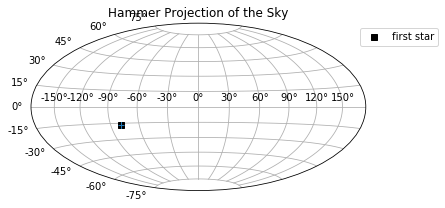

In [4]:
fig = plt.figure()
plt.subplot(111, projection="hammer")
alphas = []
deltas = []

for i, s in enumerate([sirio, sirio2]):
    alpha, delta = s.alpha-np.pi, s.delta
    #print(i, alpha, delta)
    alphas.append(alpha)
    deltas.append(delta)
    if i==0:
        plt.plot(alpha, delta, 'sk', label='first star')
    else:
        plt.plot( alpha, delta,'+')
        pass


plt.title("Hammer Projection of the Sky")
plt.legend(loc=9, bbox_to_anchor=(1.1, 1))
plt.grid(True)

# 2.- **Scan**

In [5]:
scanSirio.scan(gaia, sirio, ti=t_init, tf=t_end)
scanSirio.compute_angles_eta_zeta(gaia, sirio)  # necessary since its also clean mistaken observations
#print('How many wide times?  {}'.format(len(scanSirio.times_wide_scan)))
#print('How many coarse times?  {}'.format(len(scanSirio.times_coarse_scan)))
print('How many observation time?  {}'.format(len(scanSirio.obs_times)))
#print('How many roots?  {}'.format(len(scanSirio.roots)))
# pd.DataFrame(scanSirio.roots)


How many observation time?  33


In [6]:
print('Error: ', scanSirio.scanner_error())
print('Mean zeta:', np.mean(scanSirio.zeta_scanned))

Error:  2.1888215146094753e-14
Mean zeta: -0.00027989514546615144


# 3.- **Some Plots**

In [7]:
sat = gaia
source = sirio
satellite = gaia 
scan = scanSirio


In [8]:
def get_obs_in_CoMRS(source, sat, t):
        
    attitude = sat.func_attitude(t)
    phi, zeta = observed_field_angles(source, attitude, sat, t, double_telescope=False)  # iven if we have double telescope
    z_axis = np.array([0, 0, 1])
    field_index = np.sign(phi)
    
    eta = field_index * const.Gamma_c / 2
    
    quat1 = quaternion.from_rotation_vector(z_axis*eta)
    Sx_rot_eta = ft.rotate_by_quaternion(quat1, np.array([1, 0, 0]))
    
    
    vect = np.cross(Sx_rot_eta / np.linalg.norm(Sx_rot_eta), z_axis)
    quat2 = quaternion.from_rotation_vector(vect*zeta)
    Sx_rot_eta_zeta = ft.rotate_by_quaternion(quat2, Sx_rot_eta)
    
    obs_in_CoMRS = ft.xyz_to_lmn(attitude, Sx_rot_eta_zeta)
    return obs_in_CoMRS

def vector_error(t):
    u_lmn_unit = source.unit_topocentric_function(sat, t)
    vector_error_lmn = u_lmn_unit - sat.func_x_axis_lmn(t)  # Error vector
    vector_error_xyz = ft.lmn_to_xyz(sat.func_attitude(t), vector_error_lmn)
    return vector_error_xyz

def rad_to_mas(angle):
    """:input: angle in rad
       :output: angle in mas"""
    return angle*u.rad.to(u.mas)


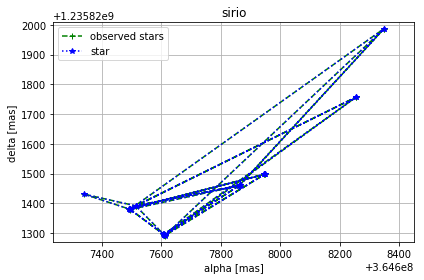

How many star_alphas:  33


In [9]:
# Note: this cell was for testing purpose and might be obsolete

alphas_obs, deltas_obs, radius_obs = ([], [], [])
star_alphas, star_deltas, star_radius = ([], [], [])
z_alphas, z_deltas = ([], [])
green_alphas, green_deltas = ([], [])

angle_list = [(star_alphas, star_deltas),
              (alphas_obs, deltas_obs),
              (z_alphas, z_deltas),
              (green_alphas, green_deltas)]

plt.figure()
# for each of the observed times we plot the position of the x-axis in lmn
# of the scanner
for i, t in enumerate(scan.obs_times):

    alpha2, delta2, _, _ = source.topocentric_angles(satellite, t)
    star_alphas.append( rad_to_mas(alpha2))
    star_deltas.append( rad_to_mas(delta2))
    # star_deltas.append(source.radius)
    
    # For the observations! ##################################
    xaxis = satellite.func_x_axis_lmn(t)
    zaxis = satellite.func_z_axis_lmn(t)
    
    """if t in scan.obs_times_PFoV:
        zaxis = satellite.func_z_axis_lmn(t+3/24)
        PFoV = get_PFoV_CoMRS(source, satellite, t)
        v_error = vector_error(t+3/24)"""
    vectorz1 = get_obs_in_CoMRS(source, satellite, t)

    green_alpha, green_delta, _ = ft.vector_to_polar(vectorz1)
    green_alphas.append(rad_to_mas(green_alpha))
    green_deltas.append(rad_to_mas(green_delta))
        
    """if t in scan.obs_times_FFoV:
        zaxis = satellite.func_z_axis_lmn(t+3/24)
        FFoV = get_FFoV_CoMRS(satellite, t)
        v_error = vector_error(t+3/24)
        vectorz1 = FFoV + v_error[2]*zaxis

        green_alpha, green_delta, _ = ft.vector_to_polar(vectorz1)
        green_alphas.append(rad_to_mas(green_alpha))
        green_deltas.append(rad_to_mas(green_delta))"""
    
    # end for observations ###################################
    
    

plt.plot(green_alphas, green_deltas, 'g+--', label='observed stars')
plt.plot(star_alphas, star_deltas, 'b*:', label='star')  # plot stars as blu stars

plt.legend(loc='upper left'), plt.title('%s' % source.name)
plt.xlabel('alpha [mas]'), plt.ylabel('delta [mas]')
plt.axis('equal'), plt.tight_layout()
plt.margins(0.1), plt.grid()
plt.show()
print('How many star_alphas: ', len(star_alphas))

# 4.- **Use Solver with scanned sources**

In [10]:
my_sirio = Calc_source(scanSirio.obs_times, source=sirio) 

print('real:', my_sirio.s_params)
my_sirio.set_params(my_sirio.s_params + my_sirio.s_params*1e-10)
print('noised:', my_sirio.s_params)
# Solver = Agis(gaia, [my_sirio], [sirio], updating='source', double_telescope=True)

real: [ 1.76766947e+00 -2.91750983e-01  1.83846196e-06 -6.94644842e-09
 -1.62464385e-08]
noised: [ 1.76766947e+00 -2.91750983e-01  1.83846196e-06 -6.94644842e-09
 -1.62464385e-08]


In [11]:
s = np.zeros(5)
sirio.reset()  # resets the source parameters at time t=0
#for i, t_L in enumerate(my_observations):
noise = 0.02 / 1
s[0] =  sirio.alpha + noise
s[1] =  sirio.delta + noise
s[2] =  sirio.parallax - sirio.parallax/ 1000
s[3] =  sirio.mu_alpha_dx + sirio.mu_alpha_dx*0.01
s[4] =  sirio.mu_delta + sirio.mu_delta*0.01

my_sirio = Calc_source('sirio', scanSirio.obs_times, s, sirio.mu_radial) 
Solver = Agis(gaia, [my_sirio], [sirio], updating='scanned source', double_telescope=True)

In [12]:
# Solver.reset_iterations()
Solver.iterate(10, verbosity=2)

***** Iteration: 1 *****
Error before iteration: 0.0007690846015725428
Error after iteration: 6.465618455219971e-07
***** Iteration: 2 *****
Error before iteration: 6.465618455219971e-07
Error after iteration: 1.198775403528222e-09
***** Iteration: 3 *****
Error before iteration: 1.198775403528222e-09
Error after iteration: 2.1241810057189383e-12
***** Iteration: 4 *****
Error before iteration: 2.1241810057189383e-12
Error after iteration: 3.765737282200486e-15
***** Iteration: 5 *****
Error before iteration: 3.765737282200486e-15
Error after iteration: 6.676185423298804e-18
***** Iteration: 6 *****
Error before iteration: 6.676185423298804e-18
Error after iteration: 1.1836069829822646e-20
***** Iteration: 7 *****
Error before iteration: 1.1836069829822646e-20
Error after iteration: 2.0984749782530555e-23
***** Iteration: 8 *****
Error before iteration: 2.0984749782530555e-23
Error after iteration: 3.722871352117777e-26
***** Iteration: 9 *****
Error before iteration: 3.722871352117777

### 4.1 **See iterations**

'running'

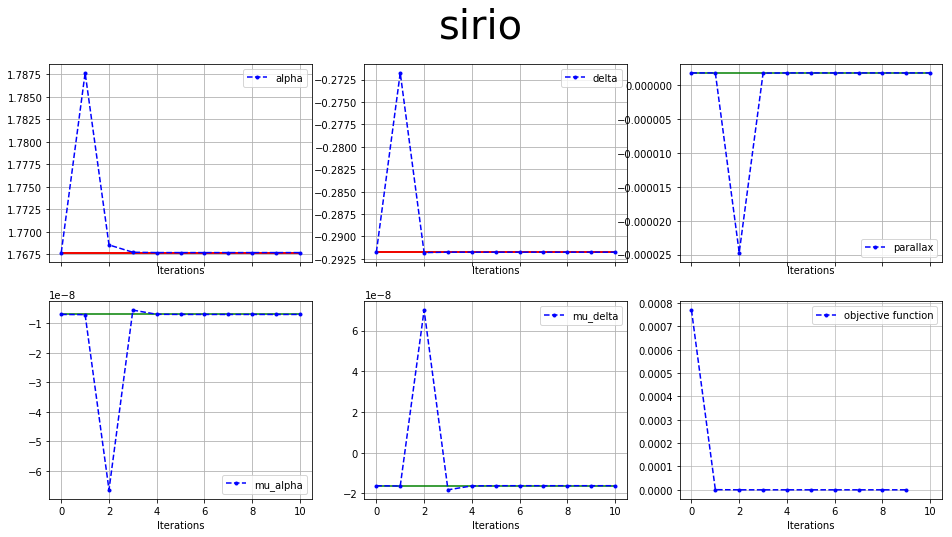

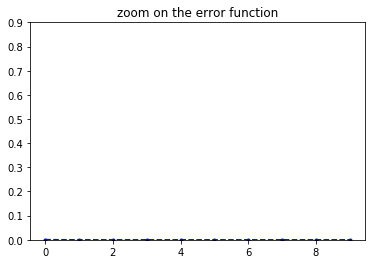

In [13]:
titles = ['sirio']
my_observations = scanSirio.obs_times
for source_index in range(len(Solver.calc_sources)):
    calc_source = Solver.calc_sources[source_index]
    real_source = Solver.real_sources[source_index]
    
    source_params = np.array(calc_source.s_old)
    fig, axs = plt.subplots(2, 3, figsize=(16,8), sharex='all')
    
    fig.suptitle(titles[source_index], fontsize=40)
    
    num_iters = len(calc_source.errors)
    labels = ['alpha', 'delta', 'parallax', 'mu_alpha', 'mu_delta']
    sirio.set_time(0)
    observed = [real_source.alpha, real_source.delta, real_source.parallax, real_source.mu_alpha_dx, real_source.mu_delta]

    alpha_list = []
    delta_list = []
    for t_L in my_observations:
        real_source.set_time(float(t_L))
        alpha_list.append(real_source.alpha)
        delta_list.append(real_source.delta)
    std_alpha = np.std(alpha_list)
    std_delta = np.std(delta_list)
    min_alpha, max_alpha = (np.min(alpha_list), np.max(alpha_list))
    min_delta, max_delta = (np.min(delta_list), np.max(delta_list))

    for i, x in enumerate(source_params.T):
        if i<3:
            ax = axs[0, i]
        else:
            ax = axs[1, i-3]
        ax.plot(x, 'b--.', label=labels[i])
        ax.hlines(observed[i], xmin=0, xmax=num_iters, color='g')
        ax.grid()
        ax.set_label('labels[i]')
        ax.set_xlabel('Iterations')
        ax.legend()

    axs[0,0].hlines(observed[0]+std_alpha, xmin=0, xmax=num_iters, color='g')
    axs[0,0].hlines(observed[0]-std_alpha, xmin=0, xmax=num_iters, color='g')
    axs[0,0].hlines(min_alpha, xmin=0, xmax=num_iters, color='r')
    axs[0,0].hlines(max_alpha, xmin=0, xmax=num_iters, color='r')

    axs[0,1].hlines(observed[1]+std_delta, xmin=0, xmax=num_iters, color='g')
    axs[0,1].hlines(observed[1]-std_delta, xmin=0, xmax=num_iters, color='g')
    axs[0,1].hlines(min_delta, xmin=0, xmax=num_iters, color='r')
    axs[0,1].hlines(max_delta, xmin=0, xmax=num_iters, color='r')

    # plot evolution of the error
    ax = axs[-1, -1] 
    ax.plot(calc_source.errors, 'b--.', label='objective function')
    # ax.set_xlim((0, num_iters))
    ax.set_xlabel('Iterations')
    ax.grid(alpha= 0.8)  
    ax.legend()


    fig.savefig('./figures/tmp/errors')

f3 = plt.figure()
plt.title('zoom on the error function')
plt.plot(calc_source.errors, 'b--.', label='objective function')
plt.ylim((0,0.9))
'running'